# Local Averages

In [2]:
import numpy as np
import scipy as sp
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import pdb

import sys
sys.path.append("../../")
import pyApproxTools as pat
importlib.reload(pat)

%matplotlib inline

## Local Averages

Now we are interested in local averages - where we integrate $v(x)$ against some compactly supported molifier function $\varphi_\varepsilon$, that is we find $\int \varphi_{\varepsilon}(x - x_0) v(x) \, \mathrm{d} x$. We find a Riesz representer $\omega_{x_0, \varepsilon}$ of this local integration, that is we define
$$
\langle \omega_{x_0, \varepsilon}, v \rangle = \int \varphi_{\varepsilon}(x - x_0) v(x) \, \mathrm{d} x 
$$

In the case where $\varphi_{\varepsilon} = \mathbb{1}_{[x_0 - \varepsilon/2, x_0 + \varepsilon/2]}$, and our space is $H_0^1([0,1])$, we have that
$$
\omega_{x_0, \varepsilon}(x) = \frac{1}{\sqrt{x_0-\varepsilon/6 + x_0^2}}
\begin{cases}
(1-x_0) x & \text{for } x \le x_0-\varepsilon/2 \\
(1-x_0) x - \frac{1}{2}\frac{(x-(x_0-\varepsilon/2))^2}{\epsilon} & \text{for } x_0 - \varepsilon/2 < x \le x_0+\varepsilon/2 \\
x_0 (1 - x)  & \text{for } x > x_0 + \varepsilon/2
\end{cases}
$$


### Projections

First we just want to see the performance of the projection on to a basis of uniformly spaced local averages for $m\to\infty$ with a variety of $\varepsilon$. We test this against a single function that is made up of sinusoids with random coefficients, i.e.
$$
v(x) = \sum_{k=1}^N \frac{y_k}{1+k^2}\sin(k \pi x)
$$
where $y_k\sim \mathcal{U}([-1,1])$ are IID uniformly distributed.

We then produce, for a variety of $\varepsilon$ (from about $1\times 10^{-2}$ to $1\times 10^{-4}$) a series of evenly spaced local averages as our basis, i.e. we take
$$
W_m = \mathrm{span}\{ \omega_{x_k, \varepsilon} : x_k = \varepsilon/2 + k / m \text{ for } k=0\ldots m-1 \}
$$
for $m$ ranging from 10 to something higher. Note that this allows the local averages to overlap.

We then plot $\| v - P_{W_m} v \|_{H_0^1}$ against $m$ for each choice of $\varepsilon$.

In [3]:
# Lets test with a function made of random sinusoids with decaying coefficients... (i.e. in some)
num_components = 200
np.random.seed(1)
v_c = 2 * np.random.random(num_components) - 1
for i in range(1,num_components+1):
    v_c[i-1] *= 1.0 / (1.0 + i*i)
v = pat.FuncVector(params=[range(1,101)], coeffs=[v_c], funcs=['H1UISin'])

Wm_plot = pat.make_unif_avg_basis(10, 0.05)
v_W, v_c = Wm_plot.project(v, return_coeffs=True)

#epsilons = [5e-2, 2.5e-2, 1e-2, 5e-3, 2.5e-3, 1e-3, 5e-4]
adj = 1 / (100*num_components + 1)
epsilons = [5e-2, 2.5e-2, 1e-2, 5e-3, 2.5e-3, 1e-3, 5e-4]
m_range = range(10,200)
err = np.zeros((len(epsilons), len(m_range)))

# Compute projection error for various epsilon and m
print('Converging uniform local averages for epsilon = ', end='')
for i, epsilon in enumerate(epsilons):
    print(str(epsilon) + '... ', end='')
    for j, m in enumerate(m_range):
        Wm = pat.make_unif_avg_basis(m, epsilon-adj)
        v_W = Wm.project(v)
        err[i,j] = (v - v_W).norm()

Converging uniform local averages for epsilon = 0.05... 0.025... 0.01... 0.005... 0.0025... 0.001... 0.0005... 

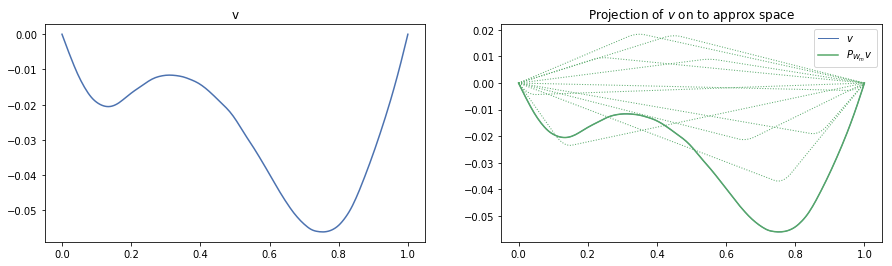

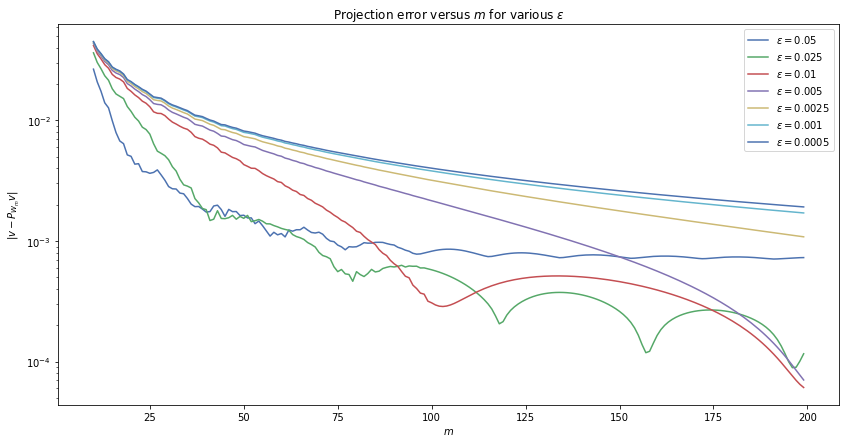

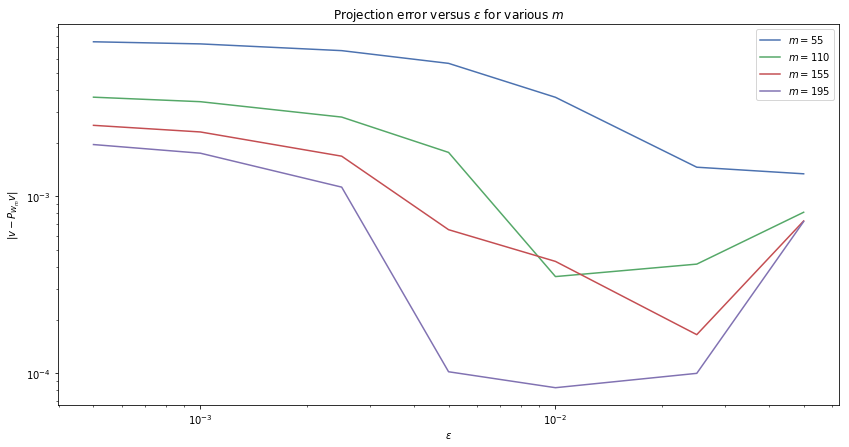

In [4]:
xs = np.arange(0.0, 1.005, 0.005)

sns.set_palette('deep')
cp = sns.color_palette()
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 2, 1, title='v')
plt.plot(xs, v.evaluate(xs), label=r'$v$')
ax = fig.add_subplot(1, 2, 2, title='Projection of $v$ on to approx space')
plt.plot(xs, v.evaluate(xs), label=r'$v$', linewidth=1)
plt.plot(xs, v_W.evaluate(xs), label=r'$P_{W_m} v$')
for i in range(Wm_plot.n):
    plt.plot(xs, (Wm_plot.vecs[i].evaluate(xs))*v_c[i], ':', linewidth=1, color=cp[1])
plt.legend()
plt.show()

# Compute projection error for various epsilon and m
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1, 1, 1, title=r'Projection error versus $m$ for various $\varepsilon$')
for i, epsilon in enumerate(epsilons):
    plt.semilogy(m_range, err[i,:], label=r'$\varepsilon={{{0}}}$'.format(epsilon))
ax.set(xlabel=r'$m$', ylabel=r'$\|v - P_{W_m} v\|$')
plt.legend()
plt.show()

# Pick some m and plot against epsilon...
ms = [55, 110, 155, 195]
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1, 1, 1, title=r'Projection error versus $\varepsilon$ for various $m$')
for i, m_sel in enumerate(ms):
    plt.loglog(epsilons, err[:,m_range.index(m_sel)], label=r'$m={{{0}}}$'.format(m_sel))
ax.set(xlabel=r'$\varepsilon$', ylabel=r'$\|v - P_{W_m} v\|$')
plt.legend()
plt.show()

### Now we try the Collective OMP and Worst-Case OMP algorithms for this problem

We look at the results both with $\varepsilon=0.01$ and $0.0025$ for both algorithms

In [31]:
N = 1e3

eps_0 = 0.06
eps_1 = 0.025
eps_2 = 0.01
eps_3 = 0.0025

dictionaries = [pat.make_unif_dictionary(N), pat.make_unif_avg_dictionary(N, eps_0),\
                pat.make_unif_avg_dictionary(N, eps_1),\
                pat.make_unif_avg_dictionary(N, eps_2), pat.make_unif_avg_dictionary(N, eps_3)]

ns = [20,40]
np.random.seed(3)
#n = 20
m = 150
bs_comp = np.zeros((len(ns), m, len(dictionaries)))
bs_wcomp = np.zeros((len(ns), m, len(dictionaries)))
bs_rand = np.zeros((len(ns), m))
bs_avg = np.zeros((len(ns), m))

Vn = pat.make_sin_basis(ns[-1])
Wms_comp = []
Wms_wcomp = []
Wms_avg = []
Wms_rand = []

for k, dictionary in enumerate(dictionaries):
    for j, n in enumerate(ns):

        gbc = pat.CollectiveOMP(dictionary, Vn.subspace(slice(0,n)), verbose=True)
        Wm_comp = gbc.construct_to_m(m)
        Wms_comp.append(Wm_comp)
        Wm_comp_o = Wm_comp.orthonormalise()

        wcgbc = pat.WorstCaseOMP(dictionary, Vn.subspace(slice(0,n)), verbose=True)
        Wm_wcomp = wcgbc.construct_to_m(m)
        Wms_wcomp.append(Wm_wcomp)
        Wm_wcomp_o = Wm_wcomp.orthonormalise()

        # For efficiency it makes sense to compute the basis pair and the associated
        # cross-gramian only once, then sub sample it as we grow m...
        BP_comp_l = pat.BasisPair(Wm_comp_o, Vn.subspace(slice(0,n)))
        BP_wcomp_l = pat.BasisPair(Wm_wcomp_o, Vn.subspace(slice(0,n)))

        for i in range(n, m):
            BP_comp = BP_comp_l.subspace(Wm_indices=slice(0,i))
            bs_comp[j, i, k] = BP_comp.beta()

            BP_wcomp =  BP_wcomp_l.subspace(Wm_indices=slice(0,i))
            bs_wcomp[j, i, k] = BP_wcomp.beta()

i 	 || P_Vn (w - P_Wm w) ||
1 : 	 999 	 0.07833854912693985
2 : 	 955 	 0.12121919047665985
3 : 	 153 	 0.20454390369387196
4 : 	 902 	 0.1354386459863655
5 : 	 736 	 0.2516393850474593
6 : 	 43 	 0.19016200095895094
7 : 	 632 	 0.15976317681329533
8 : 	 0 	 0.12367880883829928
9 : 	 849 	 0.14002026698333625
10 : 	 314 	 0.13742246891742557
11 : 	 96 	 0.13048444414472168
12 : 	 214 	 0.1757846875844056
13 : 	 426 	 0.1642083413493504
14 : 	 796 	 0.1239946842908852
15 : 	 571 	 0.20429937740038642
16 : 	 369 	 0.19783197580069573
17 : 	 686 	 0.16319899863455345
18 : 	 261 	 0.16217883727380056
19 : 	 465 	 0.08842927448302158
20 : 	 601 	 0.04332705807852641
21 : 	 182 	 0.03899491930867041
22 : 	 768 	 0.03579316357210256
23 : 	 342 	 0.021538916984057646
24 : 	 929 	 0.023376812394231283
25 : 	 68 	 0.018023230815094354
26 : 	 539 	 0.013289820262785912
27 : 	 880 	 0.009412964303460628
28 : 	 654 	 0.005795583594008016
29 : 	 22 	 0.005267337208175099
30 : 	 295 	 0.0043878811235

87 : 	 533 	 0.0002668504482548613
88 : 	 370 	 0.0002354142107209847
89 : 	 692 	 0.0002319693101875452
90 : 	 812 	 0.00019519473112083845
91 : 	 197 	 0.00019318394917212174
92 : 	 261 	 0.0003561228368087732
93 : 	 153 	 0.00026601050884701477
94 : 	 416 	 0.00024285040065734684
95 : 	 329 	 0.0002226319176975119
96 : 	 220 	 0.0001698751165530298
97 : 	 564 	 0.00016890709018826505
98 : 	 41 	 0.00016909021277410345
99 : 	 998 	 0.00016271500569702176
100 : 	 317 	 0.00018053203685609257
101 : 	 186 	 0.00020867001679802818
102 : 	 914 	 0.00017488679772043476
103 : 	 65 	 0.00016629091039115985
104 : 	 130 	 0.0002521556267267712
105 : 	 934 	 0.00017284909703362862
106 : 	 437 	 0.00017418294165273836
107 : 	 749 	 0.00016761547742018376
108 : 	 674 	 0.00015651564808536077
109 : 	 739 	 0.00015458334280519912
110 : 	 305 	 0.00014757412989283835
111 : 	 387 	 0.00013234721761169158
112 : 	 869 	 0.0001131821786856878
113 : 	 247 	 0.00010444573797169861
114 : 	 518 	 9.93982080

In [29]:
for j, n in enumerate(ns):

    Wm_rand = pat.make_random_avg_basis(m, epsilon=1.0e-2)
    Wms_rand.append(Wm_rand)
    Wm_rand_o = Wm_rand.orthonormalise()

    # For efficiency it makes sense to compute the basis pair and the associated
    # cross-gramian only once, then sub sample it as we grow m...
    BP_rand_l = pat.BasisPair(Wm_rand_o, Vn.subspace(slice(0,n)))

    for i in range(n, m):
        BP_rand = BP_rand_l.subspace(Wm_indices=slice(0,i))
        bs_rand[j, i] = BP_rand.beta()

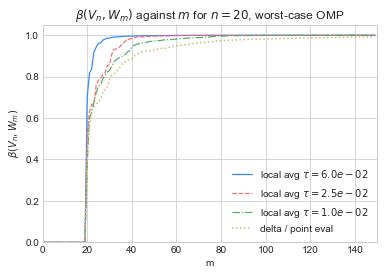

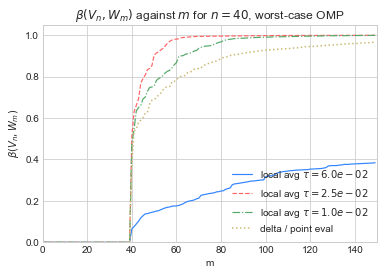

In [42]:
dict_label = [r'delta / point eval', r'local avg $\tau={{{0:0.1e}}}$'.format(eps_0), \
              r'local avg $\tau={{{0:0.1e}}}$'.format(eps_1), \
              r'local avg $\tau={{{0:0.1e}}}$'.format(eps_2), \
              r'local avg $\tau={{{0:0.1e}}}$'.format(eps_3)]

line_style = ['-', '--', '-.', '-.', '-', ':']


sns.set_palette("deep")
cp = sns.color_palette()
bl = (51/255, 133/255, 255/255)
re = (255/255, 102/255, 102/255)
cp[2] = cp[1]
cp[0] = bl
cp[1] = re
#sns.set_palette(sns.light_palette("red", reverse=True))


sns.set_style('whitegrid')

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n=20$, worst-case OMP')

for k, dictionary in enumerate(dictionaries[1:-1]):
    plt.plot(range(m), bs_wcomp[0, :, k+1], line_style[k], label=r'{0}'.format(dict_label[k+1]), lw=1.2, color=cp[k])
plt.plot(range(m), bs_wcomp[0, :, 0], line_style[-1], label=r'{0}'.format(dict_label[0]), color=cp[4])
#plt.plot(range(m), bs_rand[0, :], '-.', label=r'Random Wm'.format(n), color=cp[4])

ax.set(xlabel='m', ylabel=r'$\beta(V_n, W_m)$', xlim=[0,150], ylim=[0.,1.05])
plt.legend(loc=4)
plt.savefig('WCOMPAvgVsDelta_20_new.pdf')
plt.show()

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n=40$, worst-case OMP')

for k, dictionary in enumerate(dictionaries[1:-1]):
    plt.plot(range(m), bs_wcomp[1, :, k+1], line_style[k], label=r'{0}'.format(dict_label[k+1]), lw=1.2, color=cp[k])
plt.plot(range(m), bs_wcomp[1, :, 0], line_style[-1], label=r'{0}'.format(dict_label[0]), color=cp[4])
#plt.plot(range(m), bs_rand[1, :], '-.', label=r'Random Wm'.format(n), color=cp[4])

ax.set(xlabel='m', ylabel=r'$\beta(V_n, W_m)$', xlim=[0,150], ylim=[0.,1.05])
plt.legend(loc=4)
plt.savefig('WCOMPAvgVsDelta_40_new.pdf')
plt.show()

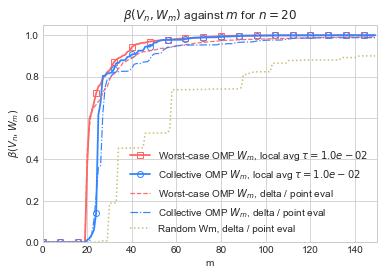

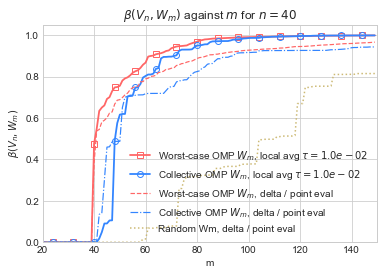

In [27]:
line_style = ['-', '--', '-.', ':']

sns.set_palette("deep")
cp = sns.color_palette()
bl = (51/255, 133/255, 255/255)
re = (255/255, 102/255, 102/255)

sns.set_style('whitegrid')

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n=20$')

k = 3
plt.plot(range(m), bs_wcomp[0, :, k], label=r'Worst-case OMP $W_m$, {0}'.format(dict_label[k]), color=re, lw=1.8, marker='s', markevery=8, markerfacecolor='none')
plt.plot(range(m), bs_comp[0, :, k], label=r'Collective OMP $W_m$, {0}'.format(dict_label[k]), color=bl, lw=1.8, marker='o', markevery=8, markerfacecolor='none')
k = 0
plt.plot(range(m), bs_wcomp[0, :, k], '--', label=r'Worst-case OMP $W_m$, {0}'.format(dict_label[k]), color=re, lw=1.2)
plt.plot(range(m), bs_comp[0, :, k], '-.', label=r'Collective OMP $W_m$, {0}'.format(dict_label[k]), color=bl, lw=1.2)
plt.plot(range(m), bs_rand[0, :], ':', label=r'Random Wm, {0}'.format(dict_label[k]), color=cp[4])

ax.set(xlabel='m', ylabel=r'$\beta(V_n, W_m)$', xlim=[0,150], ylim=[0.,1.05])
plt.legend(loc=4)
plt.savefig('COMPvsWCOMPAvg_20_new.pdf')
plt.show()

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n=40$')

k = 3
plt.plot(range(m), bs_wcomp[1, :, k], label=r'Worst-case OMP $W_m$, {0}'.format(dict_label[k]), color=re, lw=1.8, marker='s', markevery=8, markerfacecolor='none')
plt.plot(range(m), bs_comp[1, :, k], label=r'Collective OMP $W_m$, {0}'.format(dict_label[k]), color=bl, lw=1.8, marker='o', markevery=8, markerfacecolor='none')
k = 0
plt.plot(range(m), bs_wcomp[1, :, k], '--', label=r'Worst-case OMP $W_m$, {0}'.format(dict_label[k]), color=re, lw=1.2)
plt.plot(range(m), bs_comp[1, :, k], '-.', label=r'Collective OMP $W_m$, {0}'.format(dict_label[k]), color=bl, lw=1.2)

plt.plot(range(m), bs_rand[1, :], ':', label=r'Random Wm, {0}'.format(dict_label[k]), color=cp[4])
ax.set(xlabel='m', ylabel=r'$\beta(V_n, W_m)$', xlim=[20,150], ylim=[0.,1.05])
plt.legend(loc=4)
plt.savefig('COMPvsWCOMPAvg_40_new.pdf')
plt.show()

### Plot the locations of the local averages chosen for $W_m$

This is a similar plot to that we saw in ```01_omp_collective.ipynb```, where the location of the local averages that is picked by that step is also shown (only possible because the range of $\beta$ is $[0,1]$, and the domain happens to also be $[0,1]$.

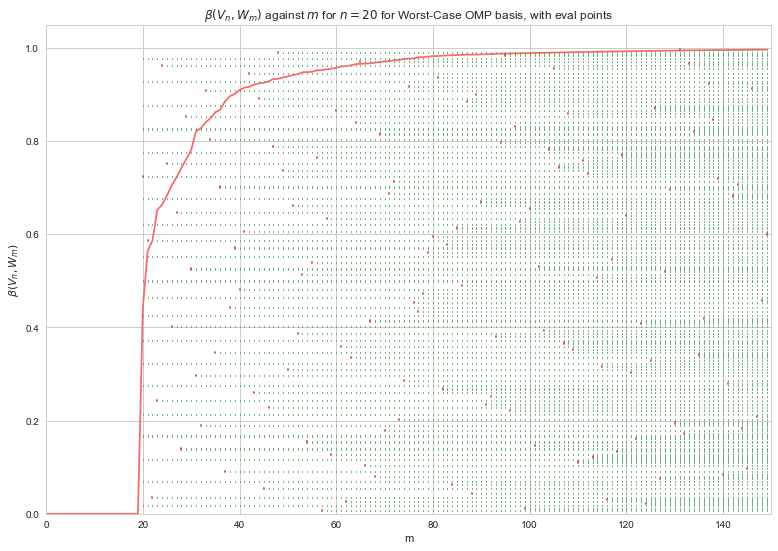

In [9]:
wc = 3 # The "width choice" in this case corresponds to 2.5e-3
nc = 0 # n choice 0 means 20
n = ns[nc]

Wm_wcomp = Wms_wcomp[2*wc + nc]
b_wcomp = bs_wcomp[nc,:,wc]
Wm_comp = Wms_comp[2*wc + nc]
b_comp = bs_comp[nc,:,wc]

# Plot the evaluation points in the Wm basss 
Wm_points = np.array([vec.params_array(0).flatten() for vec in Wm_wcomp.vecs])

line_style = ['-', '--', '-.', ':']

sns.set_palette("deep")
cp = sns.color_palette()
bl = (51/255, 133/255, 255/255)
re = (255/255, 102/255, 102/255)

sns.set_style('whitegrid')

axs = []
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for $n={{{0}}}$ for Worst-Case OMP basis, with eval points'.format(n))
ax.set(xlabel=r'$m$', ylabel=r'$\beta(V_n, W_m)$ and point locations')

plt.plot(range(m), b_wcomp, color=re, label=r'$\beta(V_n, W_m)$ for OMP $W_m$')

for k in range(20,m):

    for j in range(k-1):
        plt.plot(k * np.ones(2), Wm_points[j,:], color=cp[1], label='eval intervals', linewidth=1)
    plt.plot(k * np.ones(2), Wm_points[k-1,:], color=cp[2], markersize=6, label='New eval point')

ax.set(xlabel='m', ylabel=r'$\beta(V_n, W_m)$', xlim=[0,150], ylim=[0.,1.05])
plt.savefig('WCOMPAvgLocations_{0}.pdf'.format(n))
plt.show()

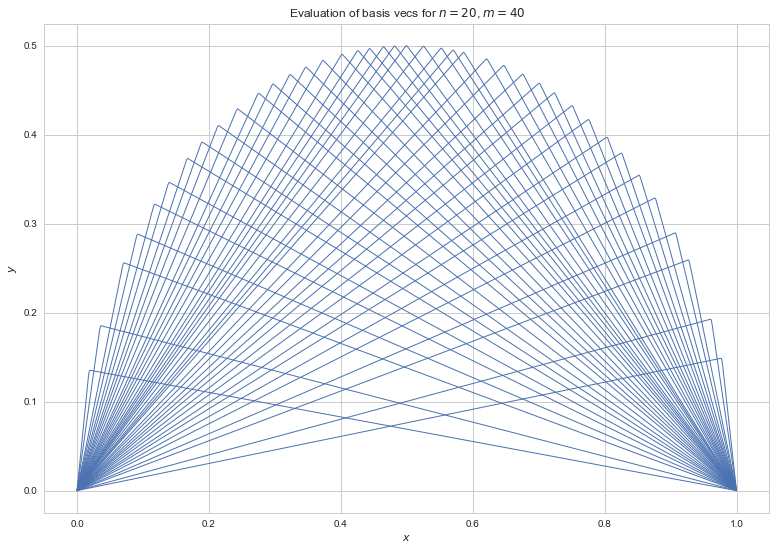

In [57]:
# Ok, so that's a more or less incomprehensible chart, what about just taking one step and checking it out?
k = 40
xs = np.arange(0,1.001,0.001)

axs = []
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(1, 1, 1, title=r'Evaluation of basis vecs for $n={{{0}}}$, $m={{{1}}}$'.format(n,k))
ax.set(xlabel=r'$x$', ylabel=r'$y$')

for j in range(k):
    plt.plot(xs, Wm_wcomp.vecs[j].evaluate(xs), color=cp[0], linewidth=1)

plt.savefig('WCOMPAvgEvaluations_{0}_{1}.pdf'.format(n, k))
plt.show()